In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d jessicali9530/kuc-hackathon-winter-2018


**Data Downloading**

In [ ]:
from zipfile import ZipFile
file_name = "kuc-hackathon-winter-2018.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done!')

Done!


**Importing all the necessary libraries**

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from bs4 import BeautifulSoup
import nltk
import pickle
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import train_test_split
import re
from tensorflow.keras import Model, Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Activation, Dense, Embedding, GlobalAveragePooling1D,Dropout,Bidirectional,LSTM
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

**Reading the data from CSV File**

---


Dataset link:- https://archive.ics.uci.edu/ml/datasets/Drug+Review+Dataset+%28Drugs.com%29 

In [ ]:
df_train = pd.read_csv("drugsComTrain_raw.csv")
df_test = pd.read_csv("drugsComTest_raw.csv")

In [ ]:
print("Train shape :" ,df_train.shape)
print("Test shape :", df_test.shape)

Train shape : (161297, 7)
Test shape : (53766, 7)


**Data Understanding**

In [ ]:
df_train.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


In [ ]:
df_train = df_train.dropna(axis=0)
df_test = df_test.dropna(axis=0)

**Data concatenation**

In [ ]:
df_all = pd.concat([df_train,df_test]).reset_index()

On the other hand, it should be noted that the phrase "3</span> users found this comment helpful" appears in the condition, which seems like an error in the crawling process. I have looked into it to see in more details.

In [ ]:
all_list = set(df_all.index)
span_list = []
for i,j in enumerate(df_all['condition']):
    if '</span>' in j:
        span_list.append(i)

In [ ]:
new_idx = all_list.difference(set(span_list))
df_all = df_all.iloc[list(new_idx)].reset_index()
del df_all['index']

In [ ]:
df_condition = df_all.groupby(['condition'])['drugName'].nunique().sort_values(ascending=False)
df_condition = pd.DataFrame(df_condition).reset_index()
df_condition.tail(20)

,condition,drugName
816,Hemangioma,1
817,Q Feve,1
818,Urinary Retention,1
819,Diagnostic Bronchograms,1
820,Steroid Responsive Inflammatory Conditions,1
821,Cluster-Tic Syndrome,1
822,Nausea (phosphorated carbohydrate solution),1
823,Ramsay Hunt Syndrome,1
824,Rat-bite Feve,1
825,Hemorrhoids (pramoxine / zinc oxide),1


In [ ]:
df_condition_1 = df_condition[df_condition['drugName']==1].reset_index()
df_condition_1['condition'][0:10]

0                           Uveitis, Posteri
1                    Pseudogout, Prophylaxis
2                        Infectious Diarrhea
3                   Thyroid Suppression Test
4                                 Angioedema
5                                Scleroderma
6                                        mis
7            Anti NMDA Receptor Encephalitis
8                                     mist (
9    Pruritus of Partial Biliary Obstruction
Name: condition, dtype: object

**Reviews Cleaning using Text Pre processing**

In [ ]:
stops = set(stopwords.words('english'))
not_stop = ["aren't","couldn't","didn't","doesn't","don't","hadn't","hasn't","haven't","isn't","mightn't","mustn't","needn't","no","nor","not","shan't","shouldn't","wasn't","weren't","wouldn't"]
for i in not_stop:
    stops.remove(i)

In [ ]:
with open('stops.pickle', 'wb') as handle:
    pickle.dump(stops, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
stemmer = SnowballStemmer('english')

def review_to_words(raw_review):
    # 1. Delete HTML 
    review_text = BeautifulSoup(raw_review, 'html.parser').get_text()
    # 2. Make a space
    letters_only = re.sub('[^a-zA-Z]', ' ', review_text)
    # 3. lower letters
    words = letters_only.lower().split()
    # 5. Stopwords 
    meaningful_words = [w for w in words if not w in stops]
    # 6. Stemming
    stemming_words = [stemmer.stem(w) for w in meaningful_words]
    # 7. space join words
    return( ' '.join(stemming_words))


In [ ]:
with open('review_to_words.pickle', 'wb') as handle:
    pickle.dump(review_to_words, handle, protocol=pickle.HIGHEST_PROTOCOL)

**Classifying reviews as positive with 1 and negative with 0 based on rating.**

In [ ]:
df_all['sentiment'] = df_all["rating"].apply(lambda x: 1 if x > 5 else 0)
df_all['review_clean'] = df_all['review'].apply(review_to_words)

Splitting the data into train data and test data

In [ ]:
df_train, df_test = train_test_split(df_all, test_size=0.33, random_state=42) 

In [ ]:
df_train.head()

,level_0,uniqueID,drugName,condition,review,rating,date,usefulCount,sentiment,review_clean
165087,166011,30482,Klonopin,Restless Legs Syndrome,"""Klonopin is as effective as turning off a swi...",9,30-Jul-08,125,1,klonopin effect turn switch no toler problem y...
186491,187534,193560,Cyclobenzaprine,Muscle Spasm,"""My back pain is about 80% gone, but I am real...",6,4-Nov-09,1,1,back pain gone realli constip sinc sunday wedn...
201271,202390,155532,Metronidazole,Bacterial Vaginitis,"""1 star rating for the pills. 10 stars for the...",5,4-Sep-14,21,0,star rate pill star cream diagnos urinari trac...
198372,199480,125305,Dulcolax,Constipation,"""I took 1 pill and about 6 hours later I was i...",3,13-Dec-15,8,0,took pill hour later extrem pain next hour cra...
204680,205811,32119,Wellbutrin XL,Depression,"""This medicine has saved my life. I was on it...",10,1-Mar-14,149,1,medicin save life sever year mg felt help quit...


**Adding the embedding layer**

In [ ]:
embedding_dim = 100    
max_length = 40        
trunc_type='post'      
padding_type='post'   
oov_tok = "<OOV>"

**Tokenising  and padding the cleaned reviews** 

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train['review_clean'])

word_index = tokenizer.word_index
vocab_size=len(word_index)

sequences = tokenizer.texts_to_sequences(df_train['review_clean'])
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [ ]:
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('pad_sequences.pickle', 'wb') as handle:
    pickle.dump(pad_sequences, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
print(vocab_size)

31057


In [ ]:
embeddings_index = {};

with open('pickle_files/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

In [ ]:
print(embeddings_matrix.shape)

(31058, 100)


In [ ]:
with open('embeddings_matrix.pickle', 'wb') as handle:
    pickle.dump(embeddings_matrix, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
sequences_test=tokenizer.texts_to_sequences(df_test['review_clean'])
padded_test = pad_sequences(sequences_test, maxlen=max_length, padding=padding_type, truncating=trunc_type)

**Making the Deep learning model using neural network**

In [ ]:
model =Sequential([
       Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
       Dropout(0.5),
       Bidirectional(LSTM(units=64, return_sequences=True)),
       Bidirectional(LSTM(units=128)),
       Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
       Dense(1, activation='sigmoid')
    ])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

num_epochs = 50

training_padded = np.array(padded)
training_labels = np.array(df_train['sentiment'])
testing_padded = np.array(padded_test)
testing_labels = np.array(df_test['sentiment'])

history = model.fit(training_padded, 
                    training_labels, 
                    epochs=num_epochs, 
                    validation_data=(testing_padded, testing_labels),
                    batch_size = 256)

print("Training Complete")


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 100)           3105800   
_________________________________________________________________
dropout (Dropout)            (None, 40, 100)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 40, 128)           84480     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               263168    
_________________________________________________________________
dense (Dense)                (None, 64)                16448     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 3,469,961
Trainable params: 364,161
Non-trainable params: 3,105,800
________________________________________

In [ ]:
model.save('sentiment_model.h5')

In [ ]:
del model

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!cp "gdrive/My Drive/pickle_files.rar" "pickle_files.rar"

from pyunpack import Archive


In [ ]:

Archive('pickle_files.rar').extractall('')
!rm "pickle_files.rar"


**Loading the trained model file**

In [ ]:
from keras.models import load_model
model = load_model('pickle_files/sentiment_model.h5')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 100)           3105800   
_________________________________________________________________
dropout (Dropout)            (None, 40, 100)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 40, 128)           84480     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               263168    
_________________________________________________________________
dense (Dense)                (None, 64)                16448     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 3,469,961
Trainable params: 364,161
Non-trainable params: 3,105,800
________________________________________

In [ ]:
p=training_padded[0]
print(training_padded.shape)

(142507, 40)


In [ ]:
type(p)

numpy.ndarray

In [ ]:
p=p.reshape(1,-1)

In [ ]:
model.predict(p)

array([[0.9899351]], dtype=float32)

In [ ]:
df_all.head()

,level_0,uniqueID,drugName,condition,review,rating,date,usefulCount,sentiment,review_clean
0,0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27,1,no side effect take combin bystol mg fish oil
1,1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192,1,son halfway fourth week intuniv becam concern ...
2,2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17,0,use take anoth oral contracept pill cycl happi...
3,3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10,1,first time use form birth control glad went pa...
4,4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37,1,suboxon complet turn life around feel healthie...


In [ ]:
def predict(p,model):
  p=p.reshape(1,-1)
  return model.predict(p)[0][0]

In [ ]:
predict(testing_padded[5],model)

0.0741496

In [ ]:
import gc
len_train = df_train.shape[0]
df_all = pd.concat([df_train,df_test])
del df_train, df_test;
gc.collect()

31220

In [ ]:
df_all['date'] = pd.to_datetime(df_all['date'])
df_all['day'] = df_all['date'].dt.day
df_all['year'] = df_all['date'].dt.year
df_all['month'] = df_all['date'].dt.month

**Predicting sentiment of review using TextBlob**

In [ ]:
from textblob import TextBlob
from tqdm import tqdm
reviews = df_all['review_clean']

Predict_Sentiment = []
for review in tqdm(reviews):
    blob = TextBlob(review)
    Predict_Sentiment += [blob.sentiment.polarity]
df_all["Predict_Sentiment"] = Predict_Sentiment
df_all.head()

100%|██████████| 212698/212698 [00:58<00:00, 3665.45it/s]


,level_0,uniqueID,drugName,condition,review,rating,date,usefulCount,sentiment,review_clean,day,year,month,Predict_Sentiment
165087,166011,30482,Klonopin,Restless Legs Syndrome,"""Klonopin is as effective as turning off a swi...",9,2008-07-30,125,1,klonopin effect turn switch no toler problem y...,30,2008,7,0.000000
186491,187534,193560,Cyclobenzaprine,Muscle Spasm,"""My back pain is about 80% gone, but I am real...",6,2009-11-04,1,1,back pain gone realli constip sinc sunday wedn...,4,2009,11,0.000000
201271,202390,155532,Metronidazole,Bacterial Vaginitis,"""1 star rating for the pills. 10 stars for the...",5,2014-09-04,21,0,star rate pill star cream diagnos urinari trac...,4,2014,9,0.023333
198372,199480,125305,Dulcolax,Constipation,"""I took 1 pill and about 6 hours later I was i...",3,2015-12-13,8,0,took pill hour later extrem pain next hour cra...,13,2015,12,-0.190278
204680,205811,32119,Wellbutrin XL,Depression,"""This medicine has saved my life. I was on it...",10,2014-03-01,149,1,medicin save life sever year mg felt help quit...,1,2014,3,-0.041667


In [ ]:
reviews = df_all['review']

Predict_Sentiment = []
for review in tqdm(reviews):
    blob = TextBlob(review)
    Predict_Sentiment += [blob.sentiment.polarity]
df_all["Predict_Sentiment2"] = Predict_Sentiment

100%|██████████| 212698/212698 [01:55<00:00, 1840.82it/s]


**creating New features for Light Gradient boosting method**

In [ ]:
import string

df_all['count_sent']=df_all["review"].apply(lambda x: len(re.findall("\n",str(x)))+1)


df_all['count_word']=df_all["review_clean"].apply(lambda x: len(str(x).split()))


df_all['count_unique_word']=df_all["review_clean"].apply(lambda x: len(set(str(x).split())))


df_all['count_letters']=df_all["review_clean"].apply(lambda x: len(str(x)))


df_all["count_punctuations"] = df_all["review"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))


df_all["count_words_upper"] = df_all["review"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))


df_all["count_words_title"] = df_all["review"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))


df_all["count_stopwords"] = df_all["review"].apply(lambda x: len([w for w in str(x).lower().split() if w in stops]))


df_all["mean_word_len"] = df_all["review_clean"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


In [ ]:
df_all['season'] = df_all["month"].apply(lambda x: 1 if ((x>2) & (x<6)) else(2 if (x>5) & (x<9) else (3 if (x>8) & (x<12) else 4)))

In [ ]:
df_train = df_all[:len_train]
df_test = df_all[len_train:]

In [ ]:
df_train.shape

(142507, 25)

In [ ]:
df_test.shape

(70191, 25)

**Light Gradient Boosting Method (LGBM)**

In [ ]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, average_precision_score
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier

#folds = KFold(n_splits=5, shuffle=True, random_state=546789)
target = df_train['sentiment']
feats = ['usefulCount','day','year','month','Predict_Sentiment','Predict_Sentiment2', 'count_sent',
 'count_word', 'count_unique_word', 'count_letters', 'count_punctuations',
 'count_words_upper', 'count_words_title', 'count_stopwords', 'mean_word_len', 'season']

sub_preds = np.zeros(df_test.shape[0])

trn_x, val_x, trn_y, val_y = train_test_split(df_train[feats], target, test_size=0.2, random_state=42) 
feature_importance_df = pd.DataFrame() 
    
clf = LGBMClassifier(
        n_estimators=10000,
        learning_rate=0.10,
        num_leaves=30,
        #colsample_bytree=.9,
        subsample=.9,
        max_depth=7,
        reg_alpha=.1,
        reg_lambda=.1,
        min_split_gain=.01,
        min_child_weight=2,
        silent=-1,
        verbose=-1,
        )

In [ ]:
clf.fit(trn_x, trn_y, 
        eval_set= [(trn_x, trn_y), (val_x, val_y)], 
        verbose=100, early_stopping_rounds=100  #30
    )

Training until validation scores don't improve for 100 rounds.
[100]	training's binary_logloss: 0.480621	valid_1's binary_logloss: 0.498753
[200]	training's binary_logloss: 0.462441	valid_1's binary_logloss: 0.493264
[300]	training's binary_logloss: 0.446657	valid_1's binary_logloss: 0.488528
[400]	training's binary_logloss: 0.432536	valid_1's binary_logloss: 0.484689
[500]	training's binary_logloss: 0.419287	valid_1's binary_logloss: 0.481016
[600]	training's binary_logloss: 0.406783	valid_1's binary_logloss: 0.477119
[700]	training's binary_logloss: 0.395193	valid_1's binary_logloss: 0.473818
[800]	training's binary_logloss: 0.383685	valid_1's binary_logloss: 0.47075
[900]	training's binary_logloss: 0.373257	valid_1's binary_logloss: 0.467513
[1000]	training's binary_logloss: 0.363796	valid_1's binary_logloss: 0.465293
[1100]	training's binary_logloss: 0.354994	valid_1's binary_logloss: 0.462927
[1200]	training's binary_logloss: 0.345802	valid_1's binary_logloss: 0.460263
[1300]	trai

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=7,
               min_child_samples=20, min_child_weight=2, min_split_gain=0.01,
               n_estimators=10000, n_jobs=-1, num_leaves=30, objective=None,
               random_state=None, reg_alpha=0.1, reg_lambda=0.1, silent=-1,
               subsample=0.9, subsample_for_bin=200000, subsample_freq=0,
               verbose=-1)

In [ ]:
sub_preds = clf.predict(df_test[feats])

**Importance of the features in LGBM**

In [ ]:
fold_importance_df = pd.DataFrame()
fold_importance_df["feature"] = feats
fold_importance_df["importance"] = clf.feature_importances_
feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

In [ ]:
feature_importance_df

,feature,importance
0,usefulCount,16941
1,day,14162
2,year,7582
3,month,8948
4,Predict_Sentiment,17626
5,Predict_Sentiment2,19362
6,count_sent,1631
7,count_word,7743
8,count_unique_word,9633
9,count_letters,13717


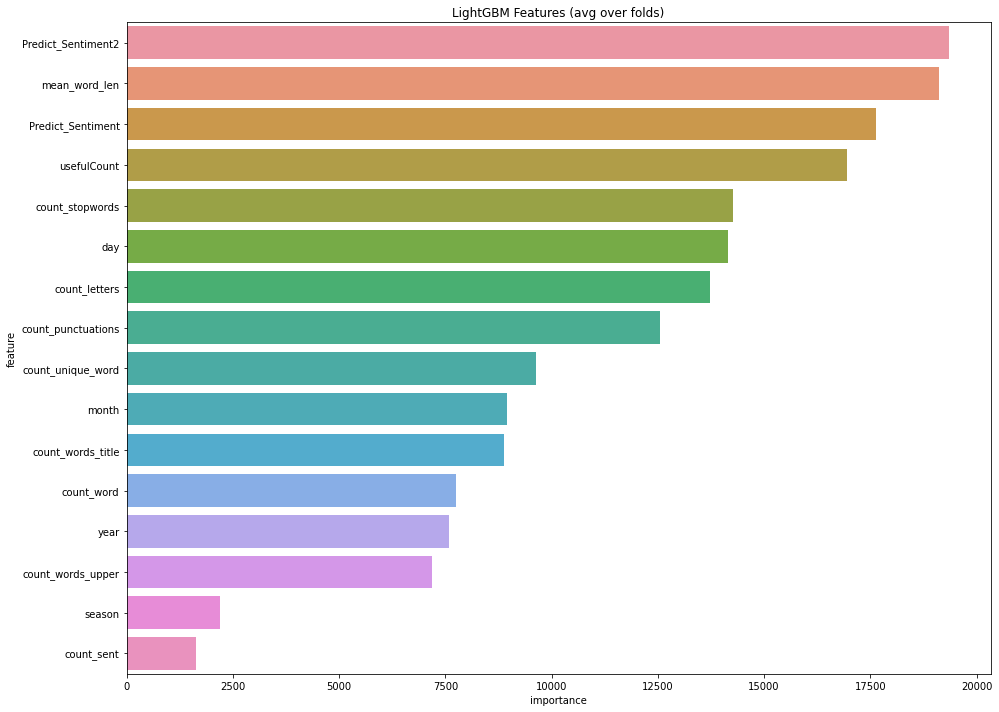

In [ ]:
import seaborn as sns
cols = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(
    by="importance", ascending=False)[:50].index

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,10))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [ ]:
!kaggle datasets download -d jylee4/dictionary

dictionary.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
from zipfile import ZipFile
file_name = "dictionary.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done!')

Done!


Because the package used for prediction of 'Predict value' is formed with movie review data, it can be unsuitable for this project which analyzes reviews for drugs. To make up for this, we conducted additional emotional analysis using the Harvard emotional dictionary.

In [ ]:
# import dictionary data
word_table = pd.read_csv("inquirerbasic.csv")

In [ ]:
##1. make list of sentiment
#Positiv word list   
temp_Positiv = []
Positiv_word_list = []
for i in range(0,len(word_table.Positiv)):
    if word_table.iloc[i,2] == "Positiv":
        temp = word_table.iloc[i,0].lower()
        temp1 = re.sub('\d+', '', temp)
        temp2 = re.sub('#', '', temp1) 
        temp_Positiv.append(temp2)

Positiv_word_list = list(set(temp_Positiv))
len(temp_Positiv)
len(Positiv_word_list)  #del temp_Positiv

#Negativ word list          
temp_Negativ = []
Negativ_word_list = []
for i in range(0,len(word_table.Negativ)):
    if word_table.iloc[i,3] == "Negativ":
        temp = word_table.iloc[i,0].lower()
        temp1 = re.sub('\d+', '', temp)
        temp2 = re.sub('#', '', temp1) 
        temp_Negativ.append(temp2)

Negativ_word_list = list(set(temp_Negativ))
len(temp_Negativ)
len(Negativ_word_list)  #del temp_Negativ

2006

In [ ]:
##2. counting the word 98590
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(vocabulary = Positiv_word_list)
content = df_test['review_clean']
X = vectorizer.fit_transform(content)
f = X.toarray()
f = pd.DataFrame(f)
f.columns=Positiv_word_list
df_test["num_Positiv_word"] = f.sum(axis=1)

vectorizer2 = CountVectorizer(vocabulary = Negativ_word_list)
content = df_test['review_clean']
X2 = vectorizer2.fit_transform(content)
f2 = X2.toarray()
f2 = pd.DataFrame(f2)
f2.columns=Negativ_word_list
df_test["num_Negativ_word"] = f2.sum(axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
##3. decide sentiment
df_test["Positiv_ratio"] = df_test["num_Positiv_word"]/(df_test["num_Positiv_word"]+df_test["num_Negativ_word"])
df_test["sentiment_by_dic"] = df_test["Positiv_ratio"].apply(lambda x: 1 if (x>=0.5) else (0 if (x<0.5) else 0.5))

df_test.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,level_0,uniqueID,drugName,condition,review,rating,date,usefulCount,sentiment,review_clean,day,year,month,Predict_Sentiment,Predict_Sentiment2,count_sent,count_word,count_unique_word,count_letters,count_punctuations,count_words_upper,count_words_title,count_stopwords,mean_word_len,season,num_Positiv_word,num_Negativ_word,Positiv_ratio,sentiment_by_dic
209701,210861,17706,Ethinyl estradiol / etonogestrel,Birth Control,"""It has been effective in preventing pregnancy...",5,2015-07-29,4,0,effect prevent pregnanc howev make feel like s...,29,2015,7,-0.086111,0.062121,1,59,45,344,39,10,13,72,4.847458,2,NaN,NaN,NaN,0.5
175323,176310,221432,Dextromethorphan,Cough,"""Took Robitussin dm cough and chest congestion...",5,2016-01-04,4,0,took robitussin dm cough chest congest dm pers...,4,2016,1,-0.471429,-0.413968,1,26,20,153,9,1,6,19,4.923077,4,NaN,NaN,NaN,0.5
116297,116956,222726,Topamax,Migraine Prevention,"""It lessened the frequency of my migraines. Bu...",5,2016-02-09,34,0,lessen frequenc migrain side effect not worth ...,9,2016,2,-0.113889,-0.129861,1,40,39,232,21,5,9,39,4.825000,4,NaN,NaN,NaN,0.5
32346,32541,164839,Phentermine / topiramate,Weight Loss,"""I am 7 years post gastric bypass had lost 90 ...",8,2017-02-06,39,1,year post gastric bypass lost lbs babi gain ba...,6,2017,2,0.000000,0.030769,1,66,58,375,20,10,18,75,4.696970,4,5.0,11.0,0.3125,0.0
190967,192038,20371,Vasotec,Left Ventricular Dysfunction,"""This medication worked great for me as far as...",9,2015-06-05,7,1,medic work great far keep bp check recov heart...,5,2015,6,0.358333,0.173810,1,35,34,200,14,7,11,39,4.742857,2,NaN,NaN,NaN,0.5


We defined Positiv_ratio = the number of positive words / (the number of positive words+the number of negative words) If the ratio is lower than 0.5, we classified as negative and if it's higher than 0.5, we classified as positive. With remainders, we classified as neutral, which includes the sentence without either positive or negative words.

In [ ]:
def userful_count(data):
    grouped = data.groupby(['condition']).size().reset_index(name='user_size')
    data = pd.merge(data,grouped,on='condition',how='left')
    return data
#___________________________________________________________
df_test =  userful_count(df_test) 
df_test['usefulCount'] = df_test['usefulCount']/df_test['user_size']

As mentioned earlier, we have normalized usefulCount by condition to solve the problem that usefulCount shows bias depending on condition. You can then add three predicted emotion values and multiply them by the normalized usefulCount to get the predicted value.

Now, we can recommend drug by condition in order of final predicted value.

In [ ]:
sub_preds_deep=[]
for i in range(len(testing_padded)):
  sub_preds_deep.append(predict(testing_padded[i],model))
  

In [ ]:
temp=sub_preds_deep

In [ ]:
df = pd.DataFrame(temp)
df.to_csv('sub_preds_deep_1.csv', index=False)

In [ ]:
df_test['deep_pred'] = sub_preds_deep
df_test['machine_pred'] = sub_preds

df_test['total_pred'] = (df_test['deep_pred'] + df_test['machine_pred'] + df_test['sentiment_by_dic'])*df_test['usefulCount']

In [ ]:
df_test = df_test.groupby(['condition','drugName']).agg({'total_pred' : ['mean']})

In [ ]:
df_test.to_csv('Final_table.csv')

In [ ]:
df_test.iloc[:,0:1]

total_pred
                                 mean
condition   drugName                 
ADHD        Adderall         0.063206
            Adderall XR      0.050291
            Adzenys XR-ODT   0.008775
            Amantadine       0.011208
            Amphetamine      0.016205
...                               ...
zen Shoulde Indocin          2.692499
            Indomethacin     3.442499
            Naproxen         4.510781
            Relafen         11.843622
            Voltaren         7.560810

[5896 rows x 1 columns]

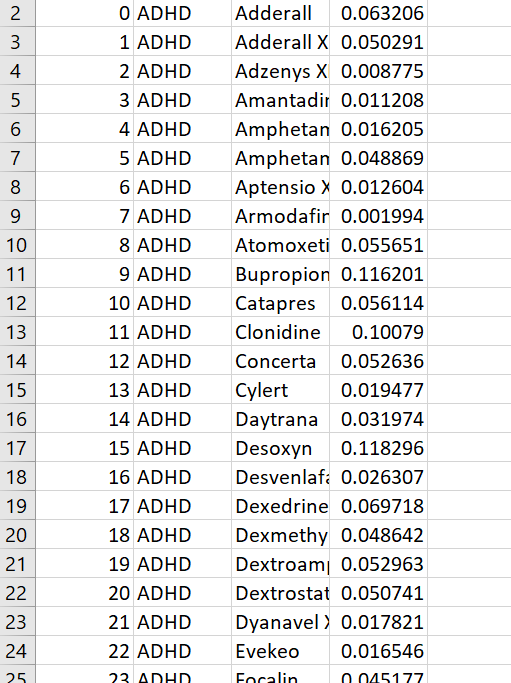

In [ ]:
df_test.columns

MultiIndex([('total_pred', 'mean')],
           )

In [ ]:
temp_file = {
    'Condition':[],
    'Drugname':[],
    'Value':[]
}

In [ ]:
x=0
with open('Final_table.csv','r') as csv_file:
    reader = csv.reader(csv_file)
    for row in reader:
      x=x+1;
      if x<4:
        continue
      else:
        temp_file['Condition'].append(row[0])
        temp_file['Drugname'].append(row[1])
        temp_file['Value'].append(row[2])

df_temp=pd.DataFrame(temp_file)
df

,0
0,0.035618
1,0.010506
2,0.001409
3,0.864268
4,0.966137
...,...
70186,0.997467
70187,0.215028
70188,0.000606
70189,0.587232


In [ ]:
len(set(df_temp['Condition']))

713

In [ ]:
df_temp.to_csv('Final_file.csv')